📊 Loading processed data...
✅ Loaded 10000 Amazon reviews
Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'sentiment', 'sentiment_label', 'binary_sentiment', 'processed_text', 'combined_text', 'processed_combined', 'text_length', 'word_count', 'processed_word_count']

📈 Data splits:
Training: 6400 samples
Validation: 1600 samples
Test: 2000 samples

Class distribution (train): [1526 4874]
Class balance: 76.16% positive

🚀 Training Basic Logistic Regression...
Validation Accuracy: 0.8163

🔧 Hyperparameter Tuning...
Running grid search... (this may take a few minutes)
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs', 'features__word_tfidf__max_features': 5000, 'features__word_tfidf__ngram_range': (1, 2)}
Best CV score: 0.8975

📊 Evaluating on Test Set...

🎯 Test Performance:
Accuracy:

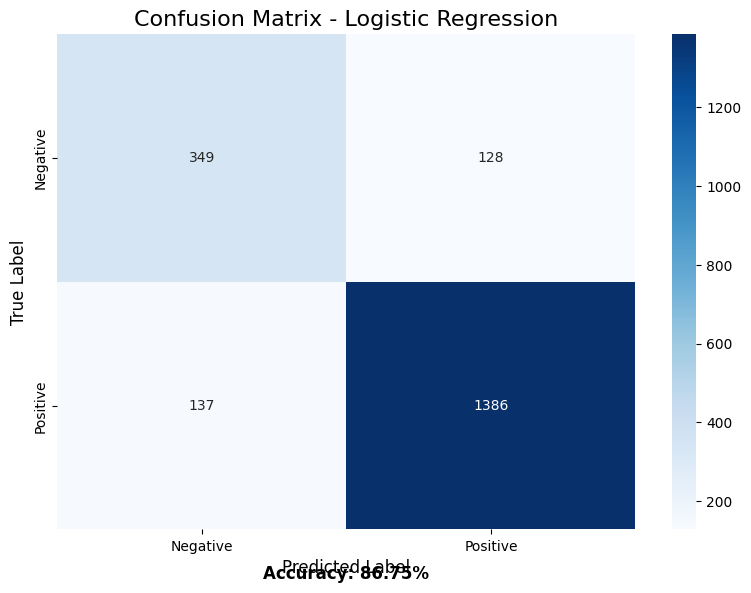

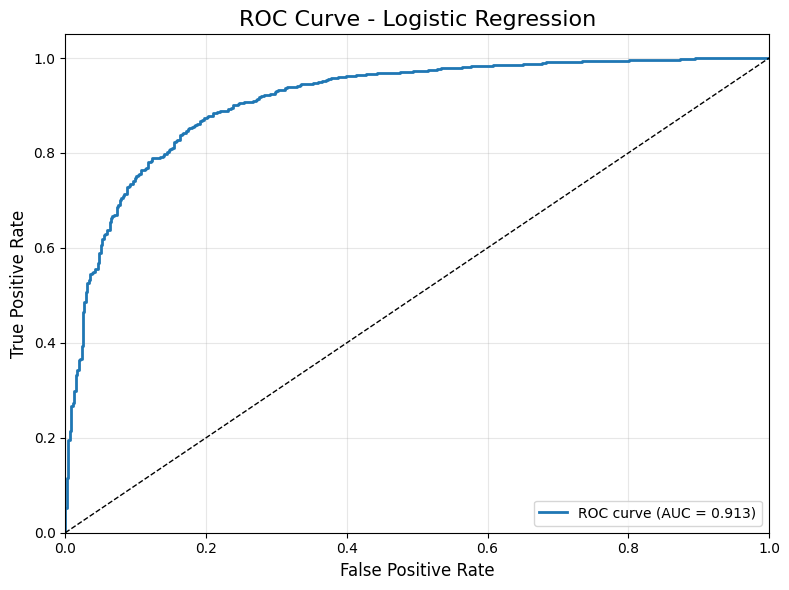

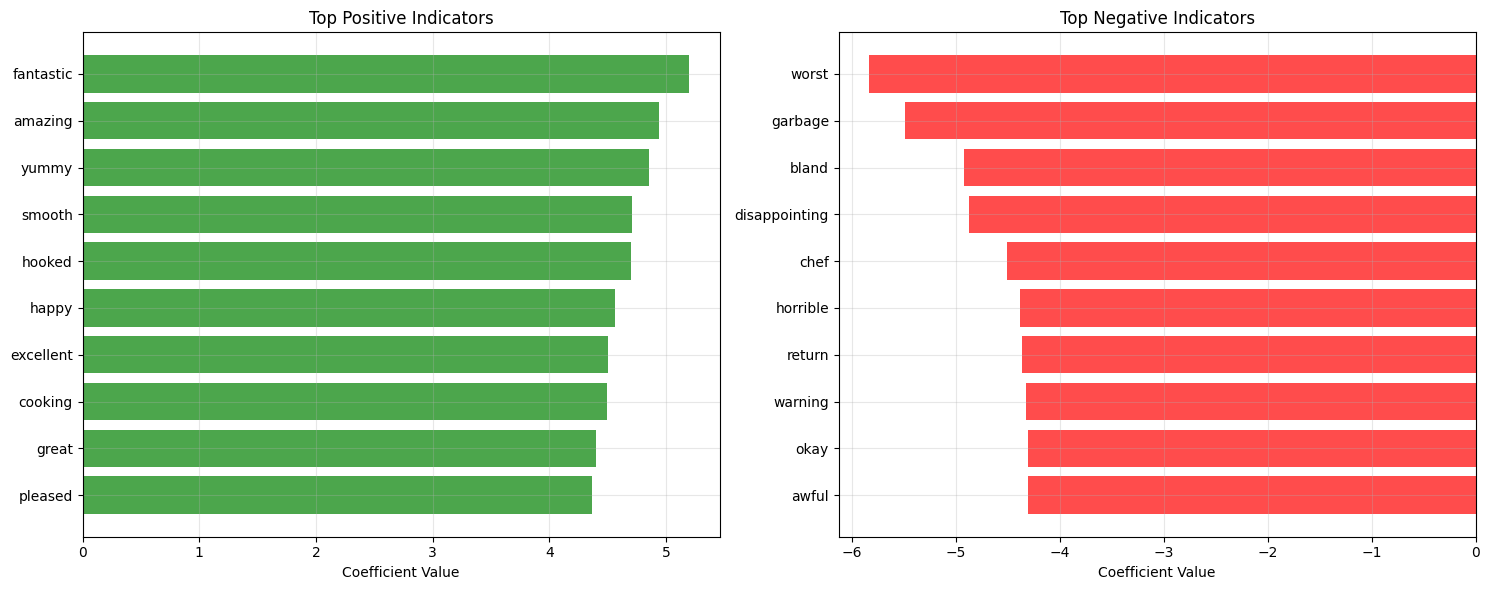


🔄 Cross-Validation Results:
F1 scores: [0.89337474 0.89921671 0.9033264  0.89051095 0.89608355]
Mean F1: 0.8965 (+/- 0.0089)

❌ Misclassified examples: 265 out of 2000

📝 Sample misclassified texts:

Text: bought mostly based review really wanted hot chocolate stephen amazon not stumbled across thought wo...
True label: Positive
Predicted: Negative
Confidence: 74.61%

Text: usually not get breakfast blend sale decided price would try not weak breakfast blend tend not bad...
True label: Positive
Predicted: Negative
Confidence: 99.16%

Text: not crazed everyone else low calorie snack fine certainly not much curb appetite though typically hu...
True label: Negative
Predicted: Positive
Confidence: 77.18%

Text: price great not like taste coffee pretty picky coffee love drink strong one produce acidic coffee ma...
True label: Negative
Predicted: Positive
Confidence: 65.26%

Text: item hard find thrilled find could buy one time...
True label: Positive
Predicted: Negative
Confidence: 62.67%


In [ ]:
#!/usr/bin/env python3
"""
Logistic Regression for Customer Support Sentiment Analysis
"""

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, roc_curve, classification_report, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

#  Load processed data
print(" Loading processed data...")
amazon_df = pd.read_csv('processed_data/amazon_processed.csv')
print(f" Loaded {len(amazon_df)} Amazon reviews")
print(f"Columns: {amazon_df.columns.tolist()}")

#  Prepare data
# Use processed text and binary sentiment
X = amazon_df['processed_text'].fillna('').values
y = amazon_df['binary_sentiment'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Further split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\n Data splits:")
print(f"Training: {len(X_train)} samples")
print(f"Validation: {len(X_val)} samples")
print(f"Test: {len(X_test)} samples")
print(f"\nClass distribution (train): {np.bincount(y_train)}")
print(f"Class balance: {np.bincount(y_train)[1] / len(y_train):.2%} positive")

#  Create feature engineering pipeline
def create_feature_pipeline():
    """Create comprehensive feature extraction pipeline"""
    
    # Word-level TF-IDF
    word_tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 3),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
        use_idf=True,
        smooth_idf=True,
        stop_words='english'
    )
    
    # Character-level TF-IDF
    char_tfidf = TfidfVectorizer(
        analyzer='char',
        ngram_range=(3, 5),
        max_features=2000,
        min_df=2,
        max_df=0.95
    )
    
    # Combine features
    features = FeatureUnion([
        ('word_tfidf', word_tfidf),
        ('char_tfidf', char_tfidf)
    ])
    
    return features

# Build and train basic model
print("\n Training Basic Logistic Regression...")

# Create pipeline
pipeline = Pipeline([
    ('features', create_feature_pipeline()),
    ('classifier', LogisticRegression(
        random_state=42,
        max_iter=1000,
        class_weight='balanced'
    ))
])

# Train
pipeline.fit(X_train, y_train)

# Evaluate on validation set
val_pred = pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val, val_pred)
print(f"Validation Accuracy: {val_accuracy:.4f}")

#  Hyperparameter tuning
print("\n Hyperparameter Tuning...")

# Define parameter grid
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear', 'lbfgs'],
    'features__word_tfidf__ngram_range': [(1, 2), (1, 3)],
    'features__word_tfidf__max_features': [3000, 5000]
}

# Grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Running grid search... (this may take a few minutes)")
grid_search.fit(X_train, y_train)

print(f"\n Best parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

# Use best model
best_model = grid_search.best_estimator_

#  Comprehensive evaluation
print("\n Evaluating on Test Set...")

# Predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
roc_auc = roc_auc_score(y_test, y_proba[:, 1])

print(f"\n Test Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# Detailed classification report
print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Visualizations
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add accuracy text
accuracy_text = f'Accuracy: {accuracy:.2%}'
plt.text(0.5, -0.1, accuracy_text, transform=plt.gca().transAxes, 
         ha='center', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#  Feature importance analysis
def get_top_features(model, n_features=20):
    """Extract top positive and negative features"""
    # Get feature names
    feature_names = model.named_steps['features'].get_feature_names_out()
    
    # Get coefficients
    coef = model.named_steps['classifier'].coef_[0]
    
    # Top positive and negative features
    top_positive_idx = np.argsort(coef)[-n_features:][::-1]
    top_negative_idx = np.argsort(coef)[:n_features]
    
    top_positive = [(feature_names[i], coef[i]) for i in top_positive_idx]
    top_negative = [(feature_names[i], coef[i]) for i in top_negative_idx]
    
    return top_positive, top_negative

# Get top features
top_pos, top_neg = get_top_features(best_model, n_features=15)

# Plot feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Positive features
features_pos = [f[0].split('__')[1] if '__' in f[0] else f[0] for f in top_pos][:10]
scores_pos = [f[1] for f in top_pos][:10]
y_pos = np.arange(len(features_pos))

ax1.barh(y_pos, scores_pos, color='green', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(features_pos)
ax1.invert_yaxis()
ax1.set_xlabel('Coefficient Value')
ax1.set_title('Top Positive Indicators')
ax1.grid(True, alpha=0.3)

# Negative features
features_neg = [f[0].split('__')[1] if '__' in f[0] else f[0] for f in top_neg][:10]
scores_neg = [f[1] for f in top_neg][:10]
y_neg = np.arange(len(features_neg))

ax2.barh(y_neg, scores_neg, color='red', alpha=0.7)
ax2.set_yticks(y_neg)
ax2.set_yticklabels(features_neg)
ax2.invert_yaxis()
ax2.set_xlabel('Coefficient Value')
ax2.set_title('Top Negative Indicators')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 9: Cross-validation
print("\n Cross-Validation Results:")
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')
print(f"F1 scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Cell 10: Error analysis
# Find misclassified examples
misclassified_idx = np.where(y_test != y_pred)[0]
print(f"\n Misclassified examples: {len(misclassified_idx)} out of {len(y_test)}")

# Show some misclassified examples
print("\n Sample misclassified texts:")
for i in misclassified_idx[:5]:
    print(f"\nText: {X_test[i][:100]}...")
    print(f"True label: {'Positive' if y_test[i] == 1 else 'Negative'}")
    print(f"Predicted: {'Positive' if y_pred[i] == 1 else 'Negative'}")
    print(f"Confidence: {y_proba[i].max():.2%}")

#Save model
print("\n Saving model...")
joblib.dump(best_model, 'logistic_regression_model.pkl')
print(" Model saved as 'logistic_regression_model.pkl'")

# Save results summary
results_summary = {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': roc_auc,
    'best_params': grid_search.best_params_,
    'cv_scores': cv_scores.tolist()
}

import json
with open('logistic_regression_results.json', 'w') as f:
    json.dump(results_summary, f, indent=4)
print(" Results saved as 'logistic_regression_results.json'")

# Interactive prediction function
def predict_sentiment(text, model=best_model):
    """Predict sentiment for new text"""
    prediction = model.predict([text])[0]
    proba = model.predict_proba([text])[0]
    
    sentiment = "Positive " if prediction == 1 else "Negative "
    confidence = proba.max()
    
    print(f"Text: {text}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2%}")
    print(f"Probability distribution: Negative={proba[0]:.2%}, Positive={proba[1]:.2%}")
    
    return prediction, proba

# Test the prediction function
print("\n🎯 Testing prediction function:")
test_texts = [
    "This product is amazing! Best purchase ever!",
    "Terrible quality, broke after one day. Very disappointed.",
    "It's okay, nothing special but does the job.",
    "Absolutely love it! Exceeded all my expectations!"
]

for text in test_texts:
    print("\n" + "-"*50)
    predict_sentiment(text)